In [2]:
import os
from dotenv import load_dotenv, find_dotenv
from openai import OpenAI
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

load_dotenv(find_dotenv())

api_key = os.environ.get("OPENAI_API_KEY")

llm = ChatOpenAI(model = "gpt-4o",api_key = api_key)
embeddings = OpenAIEmbeddings(model = "text-embedding-ada-002",api_key=api_key)

In [3]:
llm.invoke("Hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-84e2d48f-f9c9-494c-8ac2-ad3f79d689f9-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [4]:
from typing import Annotated, Dict, List
from typing_extensions import TypedDict,List,Optional
from pydantic import BaseModel, Field
# from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import ToolMessage, AIMessage

In [5]:
class AgentState(BaseModel):
    user_query:str
    task_type:Optional[str] = None
    loan_eligibility: Optional[bool] = None
    loan_documents: Optional[List[str]] = ['']

class QueryOutput(BaseModel):
    """Inputs to the Loan Guidance Tool"""
    task_type: str = Field(description = "Type of task to perform based on user_query")

In [6]:
def process_user_query(state: AgentState):
    print("Processing User Query")
    ASSISTANT_PROMPT = """
        You are an expert in managing Loan applications for users and resolving queries of users regarding the same. You are provided with a user_query
        and your task is to go through the query and return the type of task that user wants.
        <Instructions>
            1. Go through the user_query and extract all the relevant key details from the query.
            2. There are three kinds of tasks that can be performed from the query:
                a. 'Loan Eligibility Check' - User would like to check if he/she is eligible for loan.
                b. 'Loan Application Guidance' - User is looking for guidance on how to proceed with his/her Loan Application.
                c. 'Financial Advise' - User is looking for personalized financial advise based on his/her needs.
            3. Only Output the type of task that user wants and no need for any explanation.
        </Instructions>

        <Input>Query:{query}</Input>
    """
    prompt = ChatPromptTemplate.from_template(ASSISTANT_PROMPT)
    user_chain = prompt | llm.with_structured_output(QueryOutput)
    data = user_chain.invoke({"query":state.user_query})
    print(data)
    return data

In [7]:
graph_builder = StateGraph(AgentState)
#Nodes
graph_builder.add_node("process_user_query",process_user_query)
#Edges
graph_builder.add_edge(START,"process_user_query")
graph_builder.add_edge("process_user_query",END)
graph = graph_builder.compile()

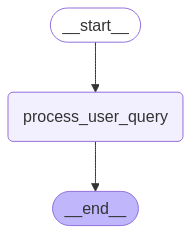

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
config = {"configurable": {"thread_id":1}}
result = graph.invoke({"user_query":"I earn $60,000 annually with a credit score of 710. Would I qualify for a home loan of $250,000?"},config)

Processing User Query
task_type='Loan Eligibility Check'


In [10]:
result = graph.invoke(
    {
    "user_query":"I've been working as a contractor in the software industry for the past 3 years with an average annual income of $85,000, though it fluctuates month to month. My credit score is around 720, and I have about $18,000 in student loan debt that I'm still paying off. I'm looking to buy a condo in the $350,000 range in Seattle, and I've saved up $40,000 for a down payment. Given my inconsistent income as a contractor and existing debt, would a bank consider me for a mortgage?"
    },
    config
)

Processing User Query
task_type='Loan Eligibility Check'


In [11]:
result = graph.invoke(
    {
    "user_query":"I started an auto loan application online but couldn't finish because I didn't have all the required documents. The system says my application will expire in 3 days. I'm still waiting on proof of insurance for the vehicle I want to purchase, and the dealership hasn't provided the final purchase agreement yet. Is there a way to extend my application time frame? And if I have to restart, will the credit check you already performed still be valid, or will you need to run another one that might further affect my credit score? I'm also wondering if I can change the loan term from 60 months to 48 months at this point without starting over."
    },
    config
)

Processing User Query
task_type='Loan Application Guidance'


### Loan Application Guidance

In [12]:
def eligibility_check(state:AgentState):
    pass
    return ""